* use 5 blocks
* different settings for adain decoder
* adain on multiple or single layer
* GAN loss for adain decoder updates
* Cycle GAN Identity Loss

In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/impressionistlandscapespaintings.zip ./
!cd /content/
!unzip impressionistlandscapespaintings.zip
!rm -f impressionistlandscapespaintings.zip
!mv /content/content/drive/MyDrive/impressionist_landscapes_resized_1024 ./
!rm -rf ./content

In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/landscape-pictures.zip ./
!mkdir landscape-pictures
!unzip landscape-pictures.zip -d /content/landscape-pictures
!rm -f landscape-pictures.zip

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output


MIN_DIM = 286
CROP_SIZE = (256, 256)

In [ ]:
STYLE_DIR = 'impressionist_landscapes_resized_1024'

styles = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
len(styles)

5000

In [ ]:
STYLE_DIR = 'landscape-pictures'

contents = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
len(contents)

4319

In [ ]:
BUFFER_SIZE = 128
STYLE_BATCH_SIZE = 7
CONTENT_BATCH_SIZE = 1

TRAIN, VAL, TEST = 0.9, 0.1, 0.0

train_style = styles[:int(TRAIN*len(styles))]
train_content = contents[:int(TRAIN*len(contents))]

val_style = styles[int(TRAIN*len(styles)):int((TRAIN+VAL)*len(styles))]
val_content = contents[int(TRAIN*len(contents)):int((TRAIN+VAL)*len(contents))]

# test_style = styles[int((TRAIN+VAL)*len(styles)):]
# test_content = contents[int((TRAIN+VAL)*len(contents)):]

In [ ]:
def resize_image(image):
    width, height, _ = tf.unstack(tf.shape(image), num=3)
    if height < width:
        new_height = MIN_DIM
        new_width = int(width * new_height / height)
    else:
        new_width = MIN_DIM
        new_height = int(height * new_width / width)

    image = tf.image.resize(image, size=(new_width, new_height))
    return image

In [ ]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = resize_image(image)
    image = tf.image.random_crop(image, size=(*CROP_SIZE, 3))
    image = tf.image.random_flip_left_right(image)
    # image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [ ]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(STYLE_BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(CONTENT_BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(STYLE_BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(CONTENT_BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
)

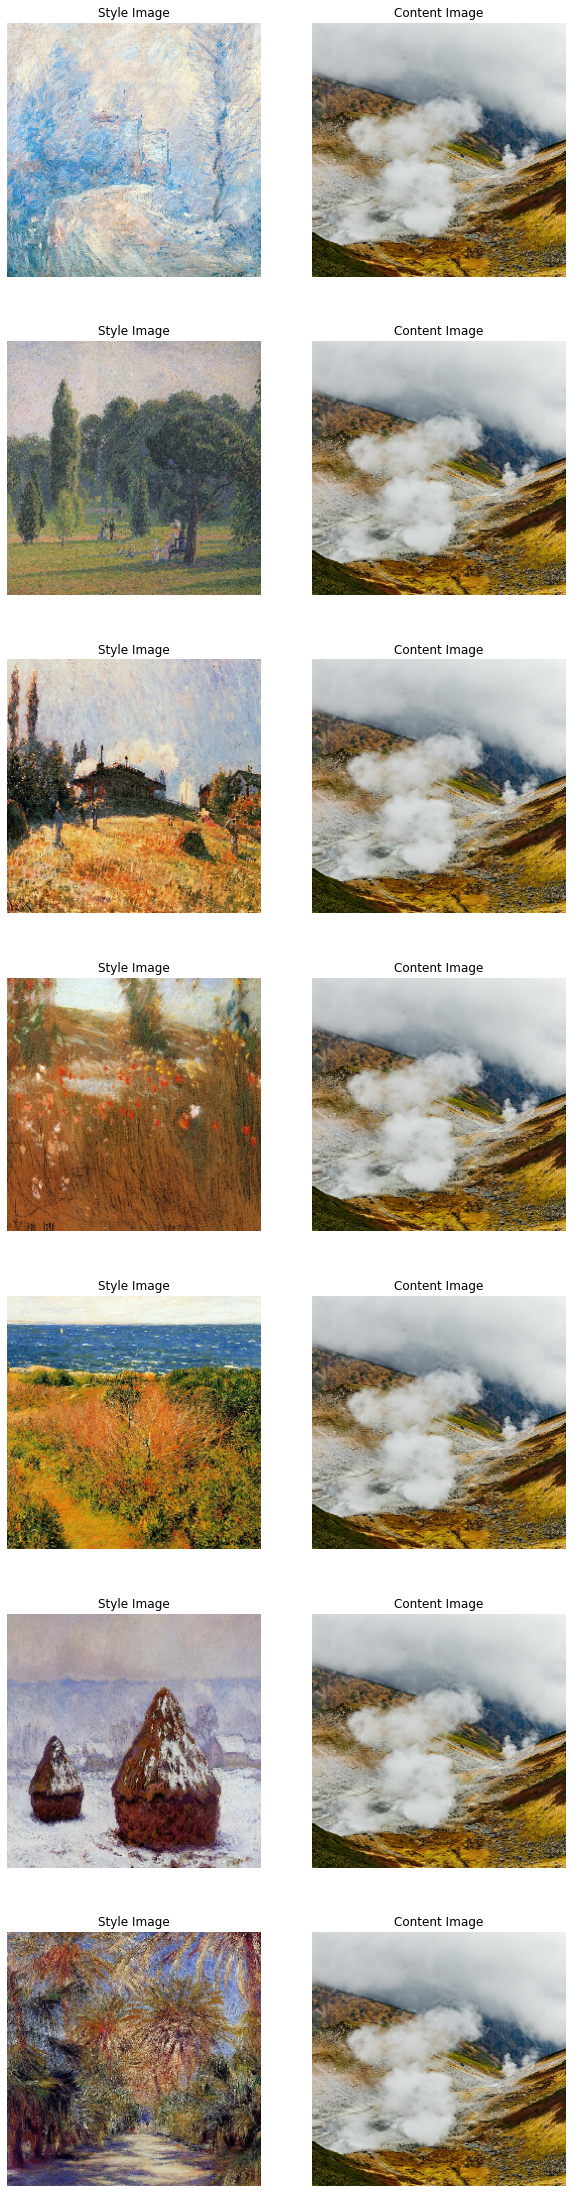

In [ ]:
style_, content_ = next(iter(train_ds))

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 40))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image) in zip(axes, style_[0:8]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_[0])
    ax_content.set_title("Content Image")

In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

content_layers = ['block4_conv1'] 

num_style_layers = len(style_layers)

In [ ]:
class VGGEncoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

        style_outputs = [vgg.get_layer(name).output for name in style_layers]
        content_outputs = [vgg.get_layer(name).output for name in content_layers]

        model_outputs = style_outputs + content_outputs

        self.vgg = tf.keras.Model(vgg.input, model_outputs)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs[:num_style_layers], outputs[-1]

In [ ]:
vgg = VGGEncoder()
inp = tf.random.normal((10, 256, 256, 3))
out, out2 = vgg(inp)
print(out[0].shape, out[1].shape, out[2].shape, out[3].shape)

80150528/80134624 [==============================] - 2s 0us/step
(10, 256, 256, 64) (10, 128, 128, 128) (10, 64, 64, 256) (10, 32, 32, 512)


In [ ]:
class Conv2DReflect(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv2d = tf.keras.layers.Conv2D(**kwargs)
        self.reflect_size = kwargs['reflect_size'] if 'reflect_size' in kwargs else 1

    def compute_output_shape(self, s):
        return s[0], s[1] + 2 * self.reflect_size, s[2] + 2 * self.reflect_size, s[3]

    def call(self, x):
        x = tf.pad(x,[[0, 0],
                      [self.reflect_size, self.reflect_size],
                      [self.reflect_size, self.reflect_size], 
                      [0, 0]], "REFLECT")
        x = self.conv2d(x)
        return x

In [ ]:
class StyleDecoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.conv2d1_1 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d1 = tf.keras.layers.UpSampling2D()

        self.conv2d1_2 = Conv2DReflect(filters=256, kernel_size=3,
                                       padding='valid', activation='relu')
        self.conv2d1_3 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d1_4 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d2_1 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d2 = tf.keras.layers.UpSampling2D()

        self.conv2d2_2 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d3_1 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d3 = tf.keras.layers.UpSampling2D()

        self.conv2d3_2 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d4_1 = Conv2DReflect(filters=3, kernel_size=3, 
                                       padding='valid', activation=None)

    def call(self, inputs):
        x = self.conv2d1_1(inputs)
        x = self.up2d1(x)

        x = self.conv2d1_2(x)
        x = self.conv2d1_3(x)
        x = self.conv2d1_4(x)
        x = self.conv2d2_1(x)
        x = self.up2d2(x)

        x = self.conv2d2_2(x)
        x = self.conv2d3_1(x)
        x = self.up2d3(x)

        x = self.conv2d3_2(x)
        x = self.conv2d4_1(x)

        return x

    def get_image_(self, inputs):
        x = self.call(inputs)
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0) * 255.
        x = tf.cast(x, tf.uint8)
        return x

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [ ]:
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = 1.0

    def mean_std_(x, epsilon=1e-5):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        std = tf.sqrt(var + epsilon)
        return mean, std

    def normalize(self,content_image_content_feature):
        contents_mean, contents_std = AdaIN.mean_std_(content_image_content_feature)
        t = (content_image_content_feature - contents_mean) / contents_std
        return self.alpha * t + (1.0-self.alpha) * content_image_content_feature

    def call(self, content_image_content_feature, styles_image_content_feature):
        contents_mean, contents_std = AdaIN.mean_std_(content_image_content_feature)
        styles_mean, styles_std = AdaIN.mean_std_(styles_image_content_feature)
        t = styles_std * (content_image_content_feature - contents_mean) / contents_std + styles_mean
        return self.alpha * t + (1.0-self.alpha) * content_image_content_feature

In [ ]:
class DownSample(tf.keras.layers.Layer):
    """Downsamples an input.
    Conv2D => Batchnorm => LeakyRelu
    Args:
        filters: number of filters
        size: filter size
        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
        apply_norm: If True, adds the batchnorm layer
    Returns:
        Downsample Sequential Model
    """
    def __init__(self, filters, size, norm_type='instancenorm', apply_norm=True):
        super().__init__()

        self.filters = filters
        self.size = size
        self.norm_type = norm_type
        self.apply_norm = apply_norm

        initializer = tf.random_normal_initializer(0., 0.02)
        self.cv1 = tf.keras.layers.Conv2D(filters, size, padding='same',
                                          activation='leaky_relu',
                                          kernel_initializer=initializer)
        self.cv2 = tf.keras.layers.Conv2D(filters, size, padding='same',
                                          activation='leaky_relu',
                                          kernel_initializer=initializer)
        self.maxp = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
        # self.act = tf.keras.layers.LeakyReLU()

        if apply_norm:
            if norm_type.lower() == 'batchnorm':
                self.norm = tf.keras.layers.BatchNormalization()
            elif norm_type.lower() == 'instancenorm':
                self.norm = InstanceNormalization()
        else:
            self.norm = tf.keras.layers.Activation('linear')

    
    def call(self, inputs):
        x = self.cv1(inputs)
        x = self.cv2(x)
        x_skip = self.norm(x)
        # x = self.act(x)
        x = self.maxp(x_skip)
        return x, x_skip

In [ ]:
down_model = DownSample(64, 3)
inp = tf.random.normal((1, 256, 256, 3))
down_result = down_model(inp)
print(down_result[0].shape, down_result[1].shape)

(1, 128, 128, 64) (1, 256, 256, 64)


In [ ]:
class UpSample(tf.keras.layers.Layer):
    """Upsamples an input.

    Conv2DTranspose => Batchnorm => Dropout => Relu

    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

    Returns:
    Upsample Sequential Model
    """
    def __init__(self, filters, size, norm_type='instancenorm', apply_norm=True, apply_dropout=False):
        super().__init__()

        initializer = tf.random_normal_initializer(0., 0.02)


        # self.transpose = tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
        #                                     padding='same',
        #                                     kernel_initializer=initializer)
        self.transpose = tf.keras.layers.UpSampling2D()
        self.cv1 = tf.keras.layers.Conv2D(filters, size, padding='same',
                                            activation='leaky_relu',
                                            kernel_initializer=initializer)
        self.cv2 = tf.keras.layers.Conv2D(filters, size, padding='same',
                                            activation='leaky_relu',
                                            kernel_initializer=initializer)

        if apply_norm:
            if norm_type.lower() == 'batchnorm':
                self.norm = tf.keras.layers.BatchNormalization()
            elif norm_type.lower() == 'instancenorm':
                self.norm = InstanceNormalization()
        else:
            self.norm = tf.keras.layers.Activation('linear')

        if apply_dropout:
            self.dropout = tf.keras.layers.Dropout(0.5)
        else:
            self.dropout = tf.keras.layers.Activation('linear')

        # self.act = tf.keras.layers.ReLU()

        self.concat = tf.keras.layers.Concatenate()


    def call(self, inputs, skip_inputs, style_inputs=None, type='skip_and_style'):
        x = self.transpose(inputs)
        if style_inputs == None:
            x = self.concat([x, skip_inputs])
        else:
            x = self.concat([x, skip_inputs, style_inputs])

        x = self.cv1(x)
        x = self.cv2(x)
        x = self.norm(x)
        x = self.dropout(x)
        # x = self.act(x)
        return x

In [ ]:
up_model = UpSample(128, 3)
inp = tf.random.normal((1, 16, 16, 256))
inp_skip = tf.random.normal((1, 32, 32, 128))
inp_style = tf.random.normal((1, 32, 32, 128))
up_result = up_model(inp, inp_skip, inp_style)
print(up_result.shape)

(1, 32, 32, 128)


In [ ]:
class UNETStyle(tf.keras.models.Model):
    def __init__(self, adain, output_channels=3, norm_type='instancenorm'):
        super().__init__()
        self.adain = adain
        initializer = tf.random_normal_initializer(0., 0.02)

        self.ds0 = DownSample(64, 3, norm_type, apply_norm=False)  # (bs, 256, 256, 3) [Input] 
                                                                   # (bs, 256, 256, 64) [Conv1] 
                                                                   # (bs, 256, 256, 64) [Conv2] ** Skip Layer
                                                                   # (bs, 128, 128, 64) [MaxPool]

        self.ds1 = DownSample(128, 3, norm_type)                   # (bs, 128, 128,  64) [Input] 
                                                                   # (bs, 128, 128, 128) [Conv1] 
                                                                   # (bs, 128, 128, 128) [Conv2] ** Skip Layer
                                                                   # (bs,  64,  64, 128) [MaxPool]

        self.ds2 = DownSample(256, 3, norm_type)                   # (bs, 64, 64, 128) [Input] 
                                                                   # (bs, 64, 64, 256) [Conv1] 
                                                                   # (bs, 64, 64, 256) [Conv2] ** Skip Layer
                                                                   # (bs, 32, 32, 256) [MaxPool]

        self.cv0 = tf.keras.layers.Conv2D(512, 3, padding='same',  # (bs, 32, 32, 512) [Input]
                                  kernel_initializer=initializer)  # (bs, 32, 32, 512) [Output]

        self.cv1 = tf.keras.layers.Conv2D(512, 3, padding='same',  # (bs, 32, 32, 512) [Input] ** AdaIN Layer Conv4-1
                                  kernel_initializer=initializer)  # (bs, 32, 32, 512) [Output]

        self.us0 = UpSample(256, 3, norm_type, apply_norm=True)    # (bs, 32, 32, 512) [Input]
                                                                   # (bs, 64, 64, 256) [ConvT]
                                                                   # (bs, 64, 64, 256 + 256) [Concat] ** Ada Layer Conv3-1
                                                                   # (bs, 64, 64, 256) [Conv1] 
                                                                   # (bs, 64, 64, 256) [Conv2]

        self.us1 = UpSample(128, 3, norm_type, apply_norm=True)    # (bs, 64, 64, 256) [Input]
                                                                   # (bs, 128, 128, 128) [ConvT]
                                                                   # (bs, 128, 128, 128 + 128) [Concat] ** Ada Layer Conv2-1
                                                                   # (bs, 128, 128, 128) [Conv1] 
                                                                   # (bs, 128, 128, 128) [Conv2]

        self.us2 = UpSample(64, 3, norm_type, apply_norm=True)     # (bs, 128, 128, 128) [Input]
                                                                   # (bs, 256, 256, 64) [ConvT]
                                                                   # (bs, 256, 256, 64 + 64) [Concat] ** Ada Layer Conv1-1
                                                                   # (bs, 256, 256, 64) [Conv1] 
                                                                   # (bs, 256, 256, 64) [Conv2]

        self.out = tf.keras.layers.Conv2D(output_channels, 1, padding='same', 
                                kernel_initializer=initializer,
                                activation='sigmoid')              # (bs, 256, 256, 3) [Output]

    # def call(self, inputs, style_layers, content_layer):
    def call(self, inputs, style_s, style_c):
        x, o0 = self.ds0(inputs)
        # o0 = adain(o0, style_s[0])

        x, o1 = self.ds1(x)
        # o1 = adain(o1, style_s[1])

        x, o2 = self.ds2(x)
        # o2 = adain(o2, style_s[2])


        x = self.cv0(x)
        x = adain(x, style_c)
        x = self.cv1(x)
        # x = adain(style_c, x)

        x = self.us0(x, o2, style_s[2])
        # x = self.us0(x, o2)

        x = self.us1(x, o1, style_s[1])
        # x = self.us1(x, o1)
        
        # x = self.us2(x, o0, style_s[0])
        x = self.us2(x, o0)

        x = self.out(x)
        return x


    def get_image_(self, inputs):
        x = self.call(inputs)
        # x = (x + 1.0) / 2.
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0) * 255.
        x = tf.cast(x, tf.uint8)
        return x

In [ ]:
# class UNETStyle(tf.keras.models.Model):
#     def __init__(self, adain, output_channels=3, norm_type='instancenorm'):
#         super().__init__()
#         self.adain = adain
#         initializer = tf.random_normal_initializer(0., 0.02)

#         vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
#         self.vgg = tf.keras.Model(vgg.input, vgg.get_layer(content_layers[0]).output)
#         self.vgg.trainable = False

#         self.norm = InstanceNormalization()

#         self.conv2d1_1 = Conv2DReflect(filters=256, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.up2d1 = tf.keras.layers.UpSampling2D()

#         self.conv2d1_2 = Conv2DReflect(filters=256, kernel_size=3,
#                                        padding='valid', activation='relu')
#         self.conv2d1_3 = Conv2DReflect(filters=256, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.conv2d1_4 = Conv2DReflect(filters=256, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.conv2d2_1 = Conv2DReflect(filters=128, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.up2d2 = tf.keras.layers.UpSampling2D()

#         self.conv2d2_2 = Conv2DReflect(filters=128, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.conv2d3_1 = Conv2DReflect(filters=64, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.up2d3 = tf.keras.layers.UpSampling2D()

#         self.conv2d3_2 = Conv2DReflect(filters=64, kernel_size=3, 
#                                        padding='valid', activation='relu')
#         self.conv2d4_1 = Conv2DReflect(filters=3, kernel_size=3, 
#                                        padding='valid', activation='sigmoid')


#     # def call(self, inputs, style_layers, content_layer):
#     def call(self, inputs, style_s, style_c):
#         inputs = inputs * 255
#         x = tf.keras.applications.vgg19.preprocess_input(inputs)
#         x = self.vgg(x)
#         # return outputs[:num_style_layers] outputs[-1]
#         # x = adain(x, style_c)

#         x = self.conv2d1_1(x)
#         x = self.up2d1(x)

#         x = self.conv2d1_2(x)
#         x = self.conv2d1_3(x)
#         x = self.conv2d1_4(x)
#         x = self.norm(x)
#         x = self.conv2d2_1(x)
#         x = self.up2d2(x)

#         x = self.conv2d2_2(x)
#         x = self.norm(x)
#         x = self.conv2d3_1(x)
#         x = self.up2d3(x)

#         x = self.conv2d3_2(x)
#         x = self.norm(x)
#         x = self.conv2d4_1(x)

#         return x


#     def get_image_(self, inputs):
#         x = self.call(inputs)
#         # x = (x + 1.0) / 2.
#         x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0) * 255.
#         x = tf.cast(x, tf.uint8)
#         return x

In [ ]:
inp = tf.random.normal((1, 256, 256, 3))

adain = AdaIN()
unet = UNETStyle(adain)
vgg = VGGEncoder()

style_l, content_l = vgg(inp)
out = unet(inp, style_l, content_l)

print(out.shape)

(1, 256, 256, 3)


In [ ]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def Discriminator(norm_type='batchnorm', target=False):
    """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
    Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
    Returns:
    Discriminator model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    if target:
        tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
        x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = tf.keras.layers.InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    if target:
        return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
disc = Discriminator()
disc.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, None, None, 64)    3072      
                                                                 
 sequential_1 (Sequential)   (None, None, None, 128)   131584    
                                                                 
 sequential_2 (Sequential)   (None, None, None, 256)   525312    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

### Losses

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
    return gan_loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)

    return real_loss + generated_loss

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return loss

In [ ]:
adain_loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
def content_loss(contents, content_targets):
    return adain_loss_fn(contents, content_targets)

In [ ]:
def style_loss_fn(style, style_target):
    style_mean, style_std = AdaIN.mean_std_(style)
    target_mean, target_std = AdaIN.mean_std_(style_target)
    return adain_loss_fn(style_mean, target_mean) + adain_loss_fn(style_std, target_std)

In [ ]:
def style_loss(styles, style_targets):
    return tf.reduce_sum([style_loss_fn(s, t) 
                            for s,t in zip(styles, style_targets)])

In [ ]:
style_weight = 2
content_weight = 1

def adain_loss(style_s, style_c, gen_s, gen_c):
    c_loss = content_loss(gen_c, style_c)
    s_loss = style_loss(gen_s, style_s)

    loss = style_weight * s_loss + content_weight * c_loss
    return loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Style Decoder

In [ ]:
!cp -r /content/drive/MyDrive/models ./

In [ ]:
style_decoder = StyleDecoder()
inp = tf.random.normal((1, 32, 32, 512))

out = style_decoder(inp)
assert out.shape == (1, 256, 256, 3)
style_decoder.load_weights('./models/d-10.h5')

In [ ]:
vgg = VGGEncoder()
adain = AdaIN()

discriminator = Discriminator()
unet = UNETStyle(adain)

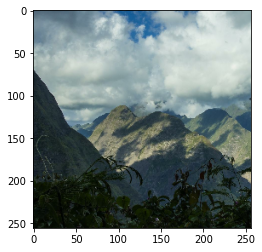

In [ ]:
_, test_image = next(iter(train_ds))
plt.imshow(test_image[0])
plt.show()

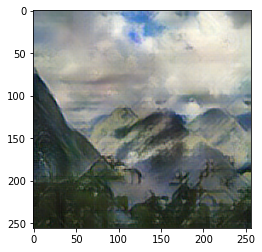

In [ ]:
out_s, out_c = vgg(test_image)
out_ = adain.normalize(out_c)
out_ = style_decoder.get_image_(out_)
plt.imshow(out_[0])
plt.show()

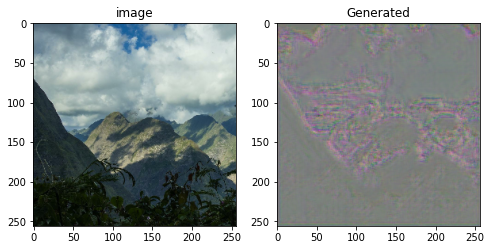

In [ ]:
out_s, out_c = vgg(out_)
generated = unet(test_image, out_s, out_c)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [test_image, generated]
title = ['image', 'Generated']

for i in range(len(imgs)):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0])

plt.show()

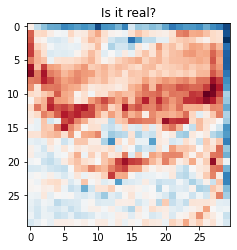

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is it real?')
plt.imshow(discriminator(test_image)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
train_g_loss = tf.keras.metrics.Mean(name="generator_loss")
train_d_loss = tf.keras.metrics.Mean(name="discriminator_loss")
train_steps = 0

In [ ]:
IOTA = 1e-2
ALPHA = 1e-6

In [ ]:
@tf.function
def train_step(input_image, style_images):

    inputs = tf.concat([input_image, style_images], 0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        style_features, content_features = vgg(inputs)
        norm_content_features = adain.normalize(content_features)

        outputs = style_decoder(norm_content_features)

        reconsts_s, reconsts_c = vgg(outputs)

        gen_output = unet(inputs, reconsts_s, reconsts_c)

        disc_real_output = discriminator(style_images)
        disc_generated_output = discriminator(gen_output[:1])

        # gen_s, gen_c = vgg(gen_output)
        # a_loss = adain_loss(reconsts_s, reconsts_c, gen_s, gen_c)

        gen_s, gen_c = vgg(gen_output[:1])
        
        a_loss = adain_loss([r[:1] for r in reconsts_s], reconsts_c[:1], gen_s, gen_c)
        i_loss = identity_loss(style_images, gen_output[1:])
        g_loss = generator_loss(disc_generated_output) + IOTA * i_loss + ALPHA * a_loss
        d_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(g_loss, unet.trainable_variables)
    discriminator_gradients = disc_tape.gradient(d_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            unet.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    train_g_loss(g_loss)
    train_d_loss(d_loss)

In [ ]:
def test_step():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    [ax.axis("off") for ax in np.ravel(axes)]
    (ax_content, ax_reconst, ax_gan) = axes

    ax_content.imshow(test_image[0])
    ax_content.set_title("Real Image")

    out_s, out_c = vgg(test_image)
    out_ = adain.normalize(out_c)
    out_ = style_decoder(out_)
    ax_reconst.imshow(out_[0])
    ax_reconst.set_title("Reconstructed Image")

    out_s, out_c = vgg(out_)
    gen_output = unet(test_image, out_s, out_c)
    ax_gan.imshow(gen_output[0])
    ax_gan.set_title("Generated Image")

    plt.show()

Steps: 97, Generator Loss: 1.001274824142456, Discriminator Loss: 1.3188246488571167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


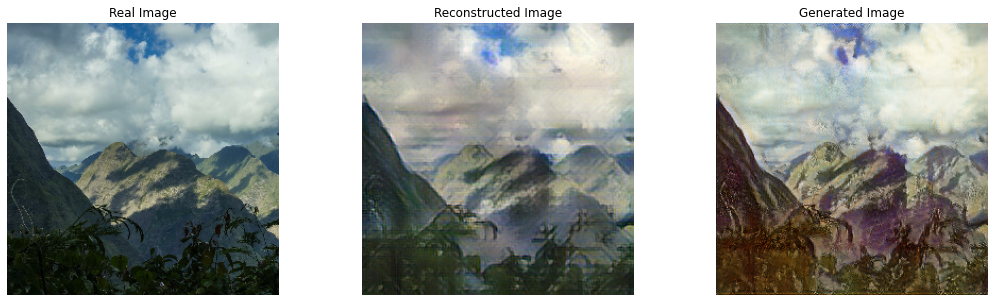

85it [01:03,  1.36it/s]

In [ ]:
epochs = 100
steps_per_epoch = 100

for i in range(epochs):
    train_steps += 1
    step = 0
    for styles, content in tqdm(train_ds):
        step += 1
        train_step(content, styles)

        if step >= steps_per_epoch:
            break

    clear_output(wait=True)
    print(
        f"Steps: {train_steps}, "
        f"Generator Loss: {train_g_loss.result()}, "
        f"Discriminator Loss: {train_d_loss.result()}"
    )
    
    test_step()

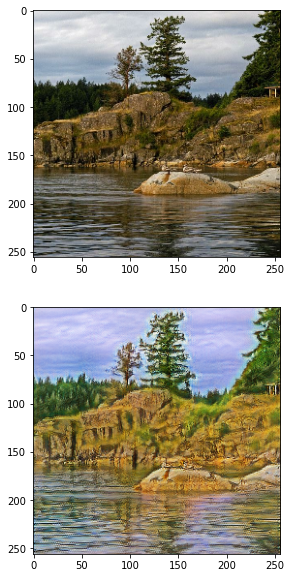

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

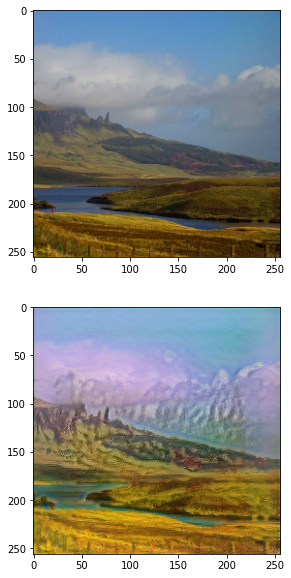

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

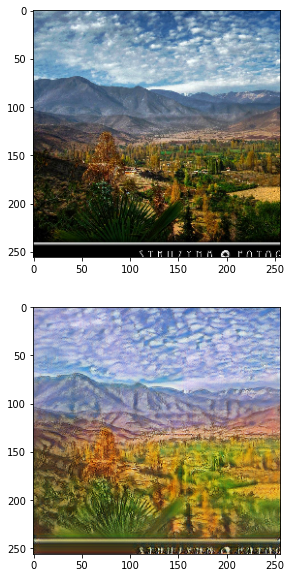

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

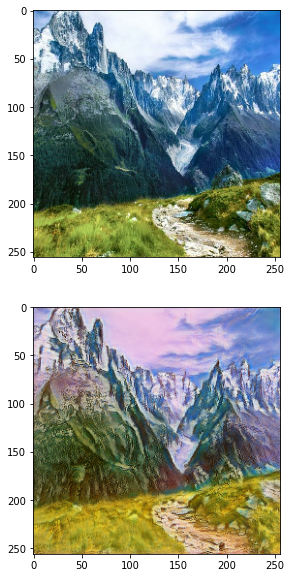

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

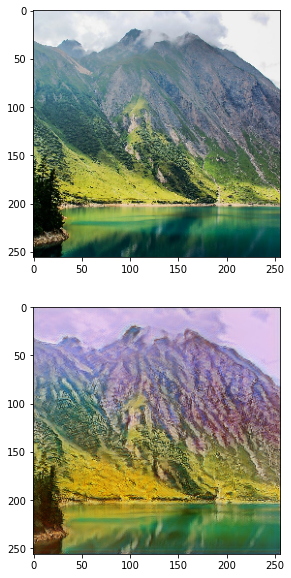

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

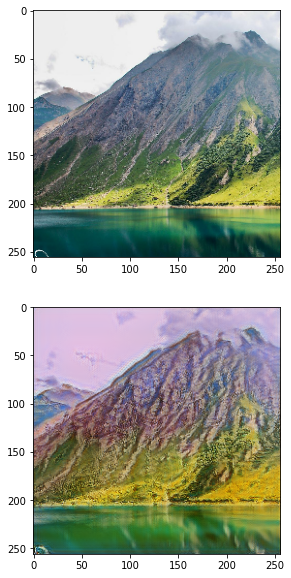

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

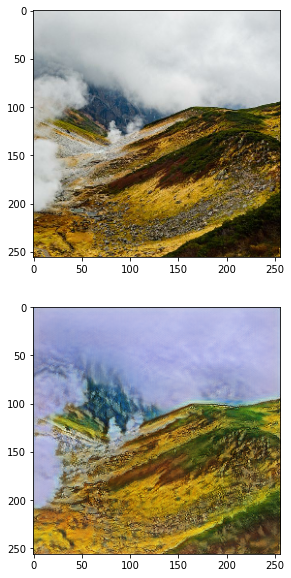

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

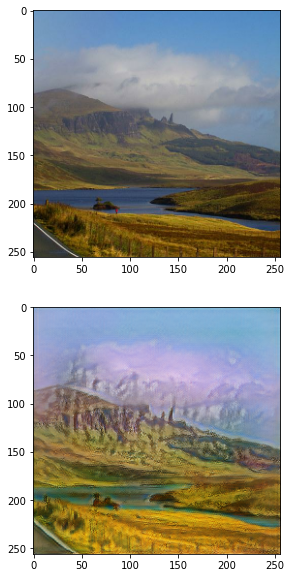

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
(ax_content, ax_gan) = axes
_, test_image = next(iter(train_ds))

ax_content.imshow(test_image[0])

out_s, out_c = vgg(test_image)
gen_output = unet(test_image, out_s, out_c)
ax_gan.imshow(gen_output[0])
plt.show()

## VGG-only


In [ ]:
class UNETStyle(tf.keras.models.Model):
    def __init__(self, adain, output_channels=3, norm_type='instancenorm'):
        super().__init__()
        self.adain = adain
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

        self.vgg = tf.keras.Model(vgg.input, content_layers)
        self.vgg.trainable = False

        self.conv2d1_1 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d1 = tf.keras.layers.UpSampling2D()

        self.conv2d1_2 = Conv2DReflect(filters=256, kernel_size=3,
                                       padding='valid', activation='relu')
        self.conv2d1_3 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d1_4 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d2_1 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d2 = tf.keras.layers.UpSampling2D()

        self.conv2d2_2 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d3_1 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d3 = tf.keras.layers.UpSampling2D()

        self.conv2d3_2 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d4_1 = Conv2DReflect(filters=3, kernel_size=3, 
                                       padding='valid', activation=None)

        initializer = tf.random_normal_initializer(0., 0.02)

        self.out = tf.keras.layers.Conv2D(output_channels, 1, padding='same', 
                                kernel_initializer=initializer,
                                activation='sigmoid')

    def call(self, inputs, style_s, style_c):
        return x


    def get_image_(self, inputs):
        x = self.call(inputs)
        # x = (x + 1.0) / 2.
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0) * 255.
        x = tf.cast(x, tf.uint8)
        return x

In [ ]:
vg = UNETStyle(None).vgg

In [ ]:
vg.summary()